# MLP를 이용하여 소 가격 예측

* 가격 변수를 이용하여 파생 변수 생성  
    * 트렌드와 계절성으로 인해 shift현상이 발생하므로 가격 변수의 잔차를 이용하여 파생변수 생성

<br/>

* train,test data set의 비중을 전체 데이터의 7:3으로 추출 하는 것보다 8:2로 추출하는 것이 더 좋음. (좀 더 시도해보기)

<br/>

* Scaler 중 MinAbs의 성능이 가장 좋음(RMSE 기준)  
    * * robust: 1398.14
    * minmax: 851.31
    * standard: 5280.23
    * maxabs: 586.69   

<br/>

* 반입량 관련 파생 변수 모두를 추가하면 성능이 낮아짐  
    * 반입량 관련 변수(소 개체 수, 수입 소고기량)
    * ** 반입량 관련 파생 변수 중 '1~2세(모든 소)'관련 변수와 '수입소고기_총량'관련 변수만 추가하는 것의 성능이 564.63으로 가장 좋음.

<br/>

* 가격 관련 파생 변수
    1. '한우 평균경매 금액_주간평균'을 분해법을 이용하여 잔차 추출 
    2. 전 주의 가격 잔차를 이용한 파생 변수 생성(y_before)
    3. 전체 주의 가격 잔차에 대한 평균 대비 전 주 가격 잔차를 이용한 파생 변수 생성(y_sd)

<br/>
   
* 반입량 관련 파생 변수
    1. '번식우 아닌 소 중 1세 미만(암,수) 제외' 변수의 전 주 대비 차이(q_diff)
    2. '1~2세(모든 소)' 변수의 전 주 대비 차이(q_diff2)
    3. '1~2세(모든 소)' 변수의 전 주 대비 차이(q_diff3)
    
---

### 환경설정

In [1]:
import pandas as pd
import os
import numpy as np
import warnings

from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

os.chdir(r'C:\Users\a0105\Desktop\DSC\ddd\preprocessing')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 전체 데이터셋 불러오기 

In [2]:
data = pd.read_pickle('전체 data.pkl')

In [3]:
data.isnull().sum()

주간날짜                        0
미국소_생산량(가격화한값)              0
번식우 아닌 소 중 1세 미만(암,수) 제외    0
1~2세(모든 소)                  0
한우 평균경매 금액_주간평균             0
돼지 탕박 경매 금액_주간평균            0
수출 (100만달러)                 0
수입 (100만달러)                 0
소비자물가지수 (2010=100)          0
수입소고기_총량                    0
평균기온                        0
최저기온                        0
최고기온                        0
평균지면온도                      2
최소상대습도(%)                   0
평균상대습도(%)                   0
dtype: int64

In [4]:
# na값 전 값으로 대체 
data['평균지면온도'] = data['평균지면온도'].fillna(method = 'pad')

In [5]:
# 복사해놓기 
data2 = data.copy()

In [6]:
data2.head(3)

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%)
0,2013-01-06,226130.0,520,888,13875.60,3044.8,559632,515586,98,28623,-0.3,-4.6,5.4,-2.5,16.0,29.6
1,2013-01-13,226130.0,520,888,13213.33,2984.0,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6
2,2013-01-20,226130.0,520,888,12588.83,2904.0,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9


### 파생변수 생성
한우 평균경매 금액_주간평균 가격을 이용하여 파생변수 생성

In [7]:
warnings.filterwarnings(action='ignore')

data['y_sd'] = ''
data['y_before'] = ''

for i in range(1,len(data['한우 평균경매 금액_주간평균'])):
    data['y_sd'][i] = data['한우 평균경매 금액_주간평균'][i-1]-np.mean(data['한우 평균경매 금액_주간평균'])
    data['y_before'][i] = data['한우 평균경매 금액_주간평균'][i-1]

In [8]:
data = data.iloc[1:,]

In [9]:
data

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before
1,2013-01-13,226130.0,520,888,13213.33,2984.00,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,-1981.17,13875.6
2,2013-01-20,226130.0,520,888,12588.83,2904.00,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,-2643.44,13213.3
3,2013-01-27,226130.0,520,888,12323.83,2959.67,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0,-3267.94,12588.8
4,2013-02-03,187340.0,520,888,12325.17,2862.83,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4,-3532.94,12323.8
5,2013-02-10,187340.0,520,888,12510.25,2109.00,559632,515586,98,18241,0.5,-3.8,4.9,0.4,21.0,37.3,-3531.6,12325.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2018-08-19,242960.0,486,887,16835.00,5305.00,604860,535202,104,42590,25.1,21.3,27.9,26.2,54.0,72.4,2479.23,18336
294,2018-08-26,242960.0,486,887,17555.00,5207.50,604860,535202,104,42590,23.2,20.9,27.2,24.5,54.0,77.4,978.231,16835
295,2018-09-02,215750.0,486,887,18369.00,5548.00,604860,535202,104,34151,22.4,19.6,25.9,24.4,40.0,60.1,1698.23,17555
296,2018-09-09,215750.0,486,887,18757.00,5754.00,604860,535202,104,34151,19.4,16.0,23.3,22.1,62.0,77.3,2512.23,18369


In [10]:
# 변수명 추출
data_names = data.drop(['주간날짜','한우 평균경매 금액_주간평균'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

['미국소_생산량(가격화한값)',
 '번식우 아닌 소 중 1세 미만(암,수) 제외',
 '1~2세(모든 소)',
 '돼지 탕박 경매 금액_주간평균',
 '수출 (100만달러)',
 '수입 (100만달러)',
 '소비자물가지수 (2010=100)',
 '수입소고기_총량',
 '평균기온',
 '최저기온',
 '최고기온',
 '평균지면온도',
 '최소상대습도(%)',
 '평균상대습도(%)',
 'y_sd',
 'y_before']

### scaling
scaler 종류
* StandardScaler: 평균과 표준편차 사용
    * 평균을 제거하고 데이터를 단위 분산으로 조정하나 이상치가 있다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 확산은 매우 달라짐.
    * 이상치가 있는 경우 균형 잡힌 척도 보장 못함.
* MinMaxScaler: 최대, 최소값이 각각 1,0이 되도록 함.
    * 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있음.(이상치에 민감)
* RobustScaler: 중앙값과 IQR사용하여 이상치의 영향을 최소화
    * 이상치의 영향을 최소화 
* MaxAbsScaler: 최대 절대값과 0이 각각 1, 0이 되도록 함.
    * 절대값이 0~1 사이로 매핑한다는 것은 값을 -1에서 1사이로 재조정한다는 것으로 이상치에 민감할 수 있음.
    

In [11]:
# 이상치에 민감하지 않은 robustsclaer적용 (돼지탕박경매금액_주간평균에 이상치가 포함되어 있었기 때문)
robust_scaler = preprocessing.RobustScaler()
np_scaled_data = robust_scaler.fit_transform(data[features])
scaled_data = data.copy()

scaled_data[features] = np_scaled_data

In [12]:
scaled_data.isnull().sum()

주간날짜                        0
미국소_생산량(가격화한값)              0
번식우 아닌 소 중 1세 미만(암,수) 제외    0
1~2세(모든 소)                  0
한우 평균경매 금액_주간평균             0
돼지 탕박 경매 금액_주간평균            0
수출 (100만달러)                 0
수입 (100만달러)                 0
소비자물가지수 (2010=100)          0
수입소고기_총량                    0
평균기온                        0
최저기온                        0
최고기온                        0
평균지면온도                      0
최소상대습도(%)                   0
평균상대습도(%)                   0
y_sd                        0
y_before                    0
dtype: int64

In [13]:
split_date = '2018-01-08'   # [208]번째부터 test (70% 추출한 것)

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

In [14]:
train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

In [15]:
train_x

,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before
1,0.765068,-0.244681,0.55,-1.632869,0.000000,0.416869,-0.666667,0.413551,-0.858025,-0.778443,-0.875776,-0.907692,-0.107143,-0.198083,-0.808186,-0.808186
2,0.765068,-0.244681,0.55,-1.717364,0.000000,0.416869,-0.666667,0.413551,-0.851852,-0.778443,-1.086957,-0.902564,0.250000,0.290735,-0.993716,-0.993716
3,0.765068,-0.244681,0.55,-1.658566,0.000000,0.416869,-0.666667,0.413551,-0.709877,-0.700599,-0.677019,-0.887179,0.250000,0.230032,-1.168666,-1.168666
4,-0.941487,-0.244681,0.55,-1.760847,0.000000,0.416869,-0.666667,-0.987718,-0.851852,-0.760479,-0.975155,-0.866667,-0.392857,-0.236422,-1.242904,-1.242904
5,-0.941487,-0.244681,0.55,-2.557034,0.000000,0.416869,-0.666667,-0.987718,-0.913580,-0.874251,-0.950311,-0.887179,-0.428571,-0.591054,-1.242529,-1.242529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.268368,-0.718085,0.00,-0.222328,0.299593,0.000000,0.666667,0.682953,-1.055556,-1.017964,-1.080745,-0.938462,-0.678571,-0.907348,0.202964,0.202964
258,0.268368,-0.718085,0.00,-2.500000,0.299593,0.000000,0.666667,0.682953,-0.827160,-0.862275,-0.801242,-0.794872,-0.500000,-0.677316,-0.090486,-0.090486
259,0.268368,-0.718085,0.00,-0.334812,0.299593,0.000000,0.666667,0.682953,-0.901235,-0.748503,-0.888199,-0.856410,-0.214286,-0.543131,-0.809334,-0.809334
260,0.268368,-0.718085,0.00,-0.878749,0.299593,0.000000,0.666667,0.682953,-0.833333,-0.742515,-0.844720,-0.825641,-0.642857,-0.840256,0.127605,0.127605


In [16]:
test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

In [17]:
test_x.head(5)

,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before
262,0.842939,-1.031915,0.05,-2.639945,0.963589,0.637234,1.333333,0.752193,-0.586420,-0.431138,-0.683230,-0.717949,-0.428571,-0.629393,0.145535,0.145535
263,0.842939,-1.031915,0.05,-0.479510,0.963589,0.637234,1.333333,0.752193,-1.395062,-1.359281,-1.285714,-1.051282,-0.678571,-0.936102,-0.008684,-0.008684
264,0.842939,-1.031915,0.05,-0.129911,0.963589,0.637234,1.333333,0.752193,-1.030864,-0.970060,-1.049689,-0.933333,-0.642857,-0.760383,-0.003782,-0.003782
265,-0.455345,-1.031915,0.05,-0.012146,0.963589,0.637234,1.333333,0.191659,-1.228395,-1.167665,-1.149068,-1.025641,-0.714286,-0.958466,0.033757,0.033757
266,-0.455345,-1.031915,0.05,-0.717153,0.963589,0.637234,1.333333,0.191659,-0.913580,-0.982036,-0.987578,-0.743590,-0.607143,-0.916933,0.223975,0.223975


In [18]:
test_y.head(5)

262    16729.5
263    16747.0
264    16881.0
265    17560.0
266    16960.0
Name: 한우 평균경매 금액_주간평균, dtype: float64

### 모델 적용

In [19]:
regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)
regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

### 시각화

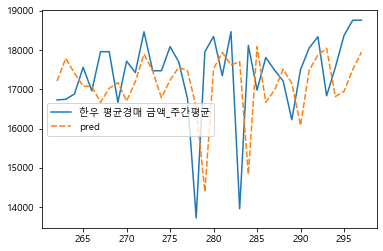

In [20]:
plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

예측된 값이 실제 값 따라 shift된 현상 즉 예측된 값이 실제 값을 따라 움직이는 문제점이 발생함. 이는 시계열 데이터에 강한 트렌드와 계절성이 포함되어 있어 결론적으로 학습이 제대로 되지 못한 것임. 이 문제를 해결하기 위해 **가격 변수에 관한 모든 파생변수는 잔차 값을 이용**

---

### 원본 전체 데이터 train, test data set 분리

In [21]:
df = data[['주간날짜','한우 평균경매 금액_주간평균']].set_index('주간날짜')

In [22]:
split_date = '2018-01-07'

train = df[df.index <= split_date].copy()
test = df[df.index > split_date].copy()

### 분해법을 이용하여 잔차 추출

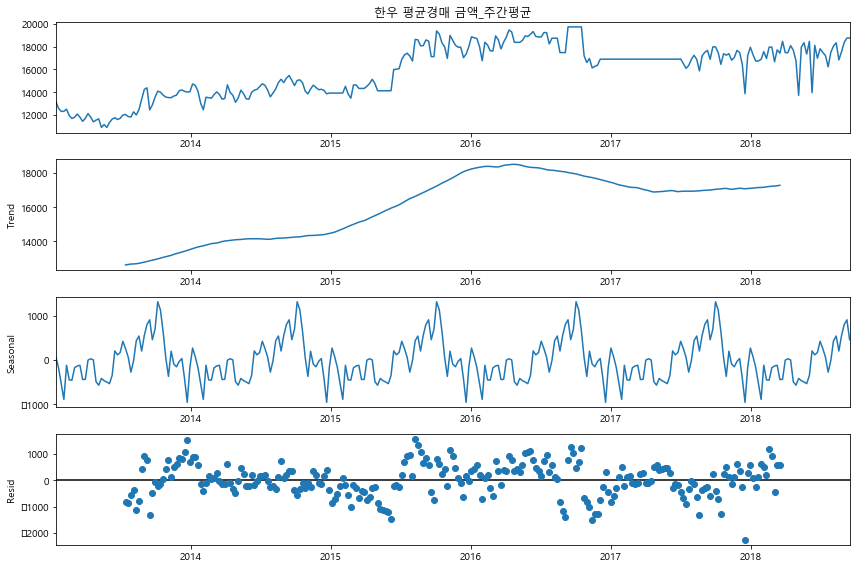

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='additive')

plt.rcParams['figure.figsize'] = [12, 8]

result_add.plot()

plt.show()


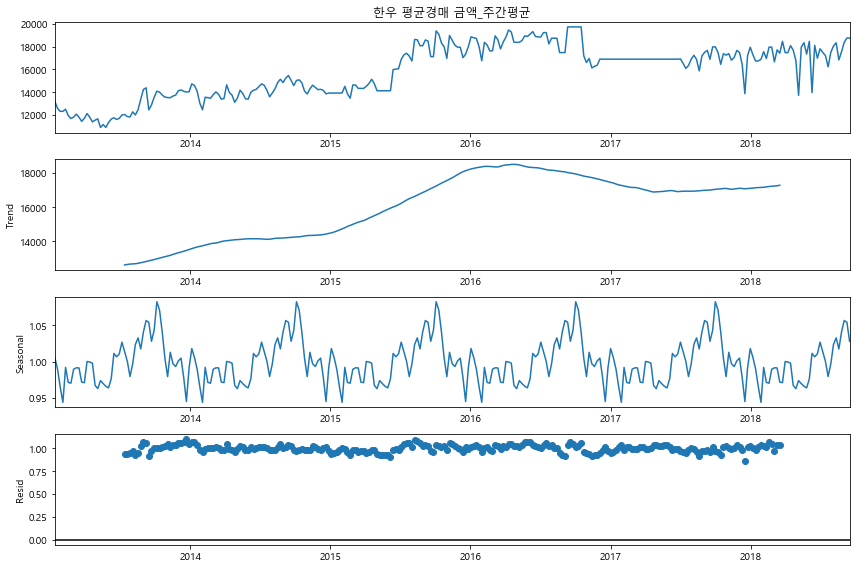

In [24]:
result_mul = seasonal_decompose(df['한우 평균경매 금액_주간평균'], model='multiple')

plt.rcParams['figure.figsize'] = [12, 8]

result_mul.plot()

plt.show()

In [25]:
result_add.resid.dropna()

주간날짜
2013-07-14    -833.200368
2013-07-21    -849.307983
2013-07-28    -569.773733
2013-08-04    -387.842002
2013-08-11   -1120.522848
                 ...     
2018-02-18    1193.662844
2018-02-25     899.429902
2018-03-04    -441.806868
2018-03-11     571.896286
2018-03-18     577.654613
Name: resid, Length: 245, dtype: float64

In [26]:
result_mul.resid.dropna()

주간날짜
2013-07-14    0.941597
2013-07-21    0.937583
2013-07-28    0.952964
2013-08-04    0.971502
2013-08-11    0.924539
                ...   
2018-02-18    1.074508
2018-02-25    1.053007
2018-03-04    0.974836
2018-03-11    1.035166
2018-03-18    1.036898
Name: resid, Length: 245, dtype: float64

#### kpss를 통해 잔차 검정

In [27]:
kpsstest = kpss(result_add.resid.dropna(), regression='ct')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
kpss_output

Test Statistic     0.057267
p-value            0.100000
Lags Used         16.000000
dtype: float64

In [28]:
kpsstest = kpss(result_mul.resid.dropna(), regression='ct')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
kpss_output

Test Statistic     0.054368
p-value            0.100000
Lags Used         16.000000
dtype: float64

검정통계량이 더 작은 승법 사용

### holt-winters 적용하여 rmse

In [29]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='add').fit()
fit1.forecast(len(test))

from sklearn.metrics import mean_squared_error

rms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))
print(rms)

1108.7730049974002


In [30]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='mul').fit()

from sklearn.metrics import mean_squared_error

rms = np.sqrt(mean_squared_error(test['한우 평균경매 금액_주간평균'], fit1.forecast(len(test))))
print(rms)

1078.3965234558787


승법의 rmse가 더 작음

---

### 잔차를 이용하여 파생 변수 생성

In [31]:
data['resid'] = pd.DataFrame(result_mul.resid).reset_index()['resid']

In [32]:
data['resid'].dropna()

26     0.941597
27     0.937583
28     0.952964
29     0.971502
30     0.924539
         ...   
266    1.074508
267    1.053007
268    0.974836
269    1.035166
270    1.036898
Name: resid, Length: 245, dtype: float64

In [33]:
data.columns

Index(['주간날짜', '미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외', '1~2세(모든 소)',
       '한우 평균경매 금액_주간평균', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)', '수입 (100만달러)',
       '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온', '평균지면온도',
       '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before', 'resid'],
      dtype='object')

In [34]:
data.head(5)

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before,resid
1,2013-01-13,226130.0,520,888,13213.33,2984.00,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,-1981.17,13875.6,NaN
2,2013-01-20,226130.0,520,888,12588.83,2904.00,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,-2643.44,13213.3,NaN
3,2013-01-27,226130.0,520,888,12323.83,2959.67,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0,-3267.94,12588.8,NaN
4,2013-02-03,187340.0,520,888,12325.17,2862.83,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4,-3532.94,12323.8,NaN
5,2013-02-10,187340.0,520,888,12510.25,2109.00,559632,515586,98,18241,0.5,-3.8,4.9,0.4,21.0,37.3,-3531.6,12325.2,NaN


In [35]:
data['y_sd'] = ''
data['y_before'] = ''

data = data.reset_index()

for i in range(1,len(data['resid'])-1):
    data['y_sd'][i] = data['resid'][i-1]-np.nanmean(data['resid'])
    data['y_before'][i+1] = data['resid'][i-1]

In [36]:
data.head(5)

,index,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before,resid
0,1,2013-01-13,226130.0,520,888,13213.33,2984.00,559632,515586,98,28623,1.4,-2.2,6.1,0.0,30.0,49.6,,,NaN
1,2,2013-01-20,226130.0,520,888,12588.83,2904.00,559632,515586,98,28623,1.5,-2.2,2.7,0.1,40.0,64.9,NaN,,NaN
2,3,2013-01-27,226130.0,520,888,12323.83,2959.67,559632,515586,98,28623,3.8,-0.9,9.3,0.4,40.0,63.0,NaN,NaN,NaN
3,4,2013-02-03,187340.0,520,888,12325.17,2862.83,559632,515586,98,18241,1.5,-1.9,4.5,0.8,22.0,48.4,NaN,NaN,NaN
4,5,2013-02-10,187340.0,520,888,12510.25,2109.00,559632,515586,98,18241,0.5,-3.8,4.9,0.4,21.0,37.3,NaN,NaN,NaN


In [37]:
data_ex = data.dropna(axis=0)

In [38]:
data_ex.columns

Index(['index', '주간날짜', '미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외',
       '1~2세(모든 소)', '한우 평균경매 금액_주간평균', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)',
       '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온',
       '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before', 'resid'],
      dtype='object')

In [39]:
data_ex.isnull().sum()

del data_ex['index']
del data_ex['resid']

In [40]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

['미국소_생산량(가격화한값)',
 '번식우 아닌 소 중 1세 미만(암,수) 제외',
 '1~2세(모든 소)',
 '돼지 탕박 경매 금액_주간평균',
 '수출 (100만달러)',
 '수입 (100만달러)',
 '소비자물가지수 (2010=100)',
 '수입소고기_총량',
 '평균기온',
 '최저기온',
 '최고기온',
 '평균지면온도',
 '최소상대습도(%)',
 '평균상대습도(%)',
 'y_sd',
 'y_before']

In [41]:
data_ex.tail(5)

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before
265,2018-02-11,198390.0,372,868,16960.0,3851.0,604860,535202,104,26979,0.5,-5.6,4.3,3.2,16.0,27.1,0.0140651,1.03056
266,2018-02-18,198390.0,372,868,17957.0,3856.0,604860,535202,104,26979,2.8,0.4,8.4,4.0,16.0,31.1,0.0733552,1.01522
267,2018-02-25,198390.0,372,868,17957.0,3856.0,604860,535202,104,26979,3.9,-1.3,7.5,5.3,40.0,61.4,0.0518542,1.07451
268,2018-03-04,220350.0,372,868,16668.5,3999.0,604860,535202,104,32146,2.6,-0.4,7.7,4.1,48.0,71.3,-0.0263172,1.05301
269,2018-03-11,220350.0,372,868,17716.0,4011.0,604860,535202,104,32146,10.6,1.3,18.5,9.0,26.0,50.0,0.034013,0.974836


In [42]:
data_ex.head(5)

,주간날짜,미국소_생산량(가격화한값),"번식우 아닌 소 중 1세 미만(암,수) 제외",1~2세(모든 소),한우 평균경매 금액_주간평균,돼지 탕박 경매 금액_주간평균,수출 (100만달러),수입 (100만달러),소비자물가지수 (2010=100),수입소고기_총량,평균기온,최저기온,최고기온,평균지면온도,최소상대습도(%),평균상대습도(%),y_sd,y_before
27,2013-07-21,229410.0,673,915,11867.2,3789.80,559632,515586,98,20772,28.7,25.1,31.5,29.0,49.0,61.0,-0.0635701,0.941597
28,2013-07-28,229410.0,673,915,11830.0,4051.80,559632,515586,98,20772,25.9,23.9,29.5,28.7,57.0,79.9,-0.0481893,0.937583
29,2013-08-04,224120.0,673,915,12281.5,4378.67,559632,515586,98,20007,31.1,28.4,35.0,35.5,44.0,54.5,-0.0296507,0.952964
30,2013-08-11,224120.0,673,915,12010.8,3972.00,559632,515586,98,20007,31.3,28.0,35.5,34.3,33.0,48.0,-0.076614,0.971502
31,2013-08-18,224120.0,673,915,12470.0,3968.60,559632,515586,98,20007,27.9,23.4,31.1,32.9,38.0,64.3,-0.0515734,0.924539


In [43]:
# 이상치에 민감하지 않은 robustsclaer적용 (돼지탕박경매금액_주간평균에 이상치가 포함되어 있었기 때문)
robust_scaler = preprocessing.RobustScaler()
np_scaled_data = robust_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

In [44]:
data_ex.shape

(243, 18)

In [45]:
data_ex.isnull().sum()

주간날짜                        0
미국소_생산량(가격화한값)              0
번식우 아닌 소 중 1세 미만(암,수) 제외    0
1~2세(모든 소)                  0
한우 평균경매 금액_주간평균             0
돼지 탕박 경매 금액_주간평균            0
수출 (100만달러)                 0
수입 (100만달러)                 0
소비자물가지수 (2010=100)          0
수입소고기_총량                    0
평균기온                        0
최저기온                        0
최고기온                        0
평균지면온도                      0
최소상대습도(%)                   0
평균상대습도(%)                   0
y_sd                        0
y_before                    0
dtype: int64

In [46]:
data_ex.iloc[170]  #243*0.7

주간날짜                        2016-10-23 00:00:00
미국소_생산량(가격화한값)                           221120
번식우 아닌 소 중 1세 미만(암,수) 제외                    476
1~2세(모든 소)                                  854
한우 평균경매 금액_주간평균                           17191
돼지 탕박 경매 금액_주간평균                           4541
수출 (100만달러)                              495426
수입 (100만달러)                              406193
소비자물가지수 (2010=100)                          101
수입소고기_총량                                  30306
평균기온                                       12.4
최저기온                                       10.8
최고기온                                       16.7
평균지면온도                                     13.6
최소상대습도(%)                                    54
평균상대습도(%)                                  74.6
y_sd                                 -0.0413653
y_before                                 1.0612
Name: 197, dtype: object

In [47]:
data_ex.iloc[195]  #243*0.8

주간날짜                        2017-04-16 00:00:00
미국소_생산량(가격화한값)                           196310
번식우 아닌 소 중 1세 미만(암,수) 제외                    500
1~2세(모든 소)                                  862
한우 평균경매 금액_주간평균                           16900
돼지 탕박 경매 금액_주간평균                           4530
수출 (100만달러)                              573694
수입 (100만달러)                              478478
소비자물가지수 (2010=100)                          102
수입소고기_총량                                  24237
평균기온                                       13.9
최저기온                                       10.3
최고기온                                       20.7
평균지면온도                                     15.7
최소상대습도(%)                                    23
평균상대습도(%)                                  49.3
y_sd                               -0.000564352
y_before                               0.995841
Name: 222, dtype: object

### train, test data set 분리

In [48]:
split_date = '2017-04-16'

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

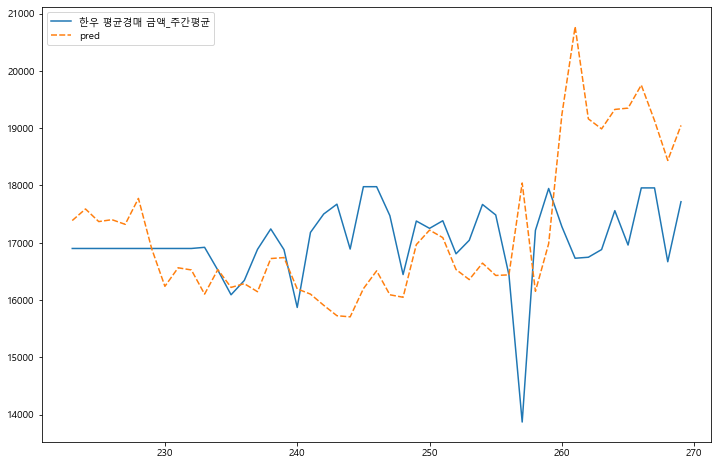

In [49]:
train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']


regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])


In [50]:
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))

Root mean squared error:  1398.140029421992
mean absolute error:  32.317026417802744


### minmaxscaler 

Root mean squared error:  851.3139294067618
mean absolute error:  26.357312104937403
---


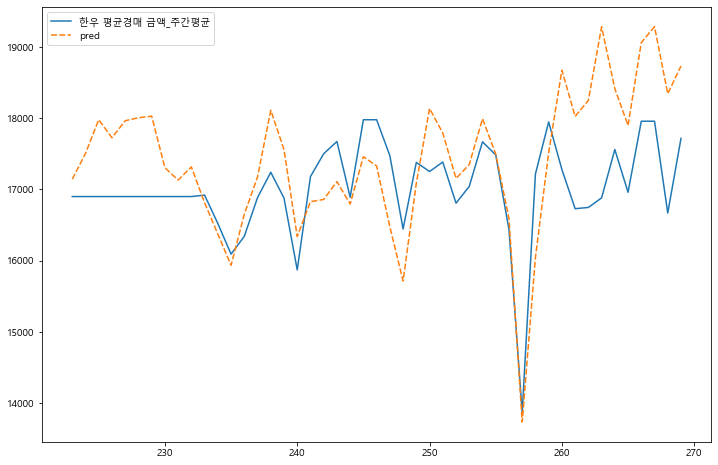

In [51]:
# 이상치에 민감하지 않은 robustsclaer적용 (돼지탕박경매금액_주간평균에 이상치가 포함되어 있었기 때문)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled_data = min_max_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

### StandardScaler

Root mean squared error:  2580.228381522501
mean absolute error:  42.36099005311659
---


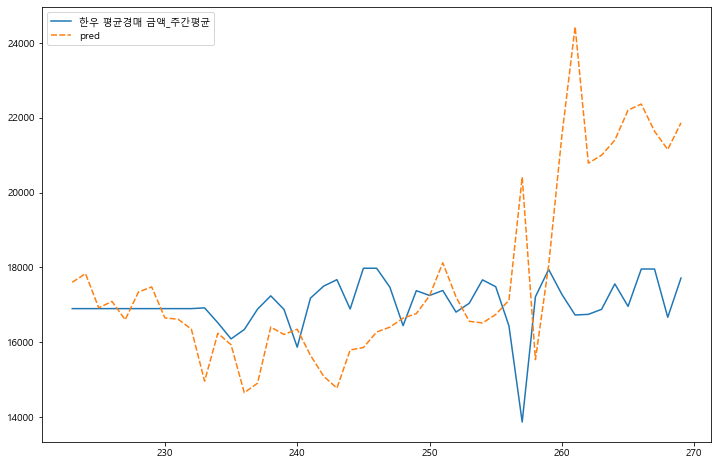

In [52]:
# 이상치에 민감하지 않은 robustsclaer적용 (돼지탕박경매금액_주간평균에 이상치가 포함되어 있었기 때문)
stan_scaler = preprocessing.StandardScaler()
np_scaled_data = stan_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred


plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

### MaxAbsScaler

['미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외', '1~2세(모든 소)', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before']
Root mean squared error:  586.692753466873
mean absolute error:  21.789785113141896
---


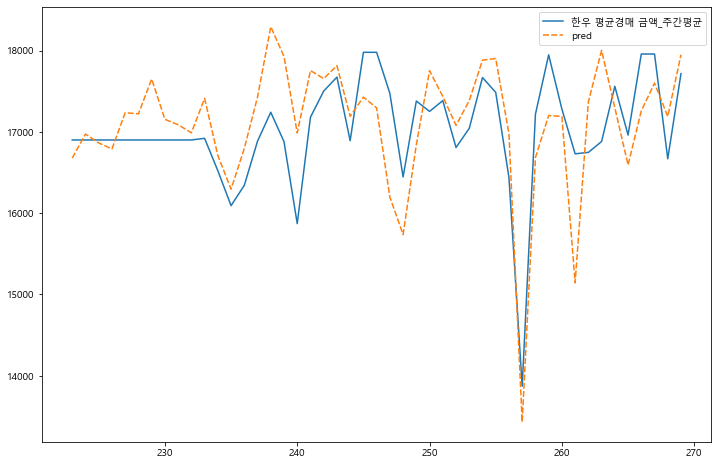

In [53]:
print(features)
ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)
pred

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

(rmse기준)
* robust: 1398.14
* minmax: 851.31
* standard: 5280.23
* maxabs: 586.69   
**MaxAbsScaler를 이용하는 것이 성능이 더 좋음**

### 소 개체 수 데이터에서 추출한 변수 2개 비교
#### '번식우 아닌 소 중 1세 미만(암,수) 제외' 변수 제외

Root mean squared error:  1010.1780836338738
mean absolute error:  28.58142831318695
---


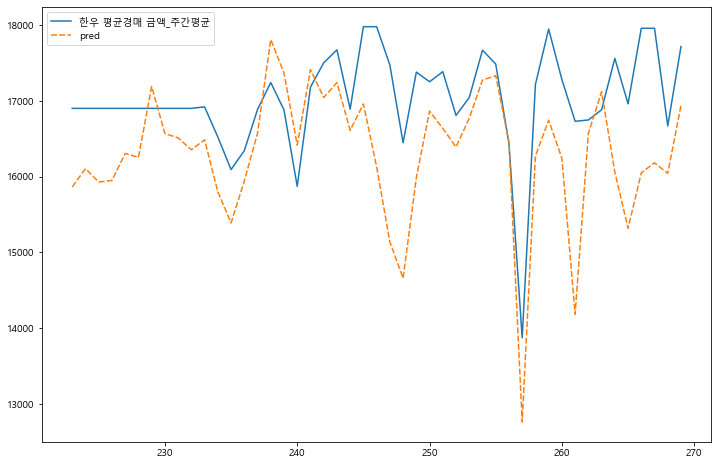

In [54]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','번식우 아닌 소 중 1세 미만(암,수) 제외'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

#### '1~2세(모든 소)' 변수 제외

Root mean squared error:  634.707211475463
mean absolute error:  23.22464772746389
---


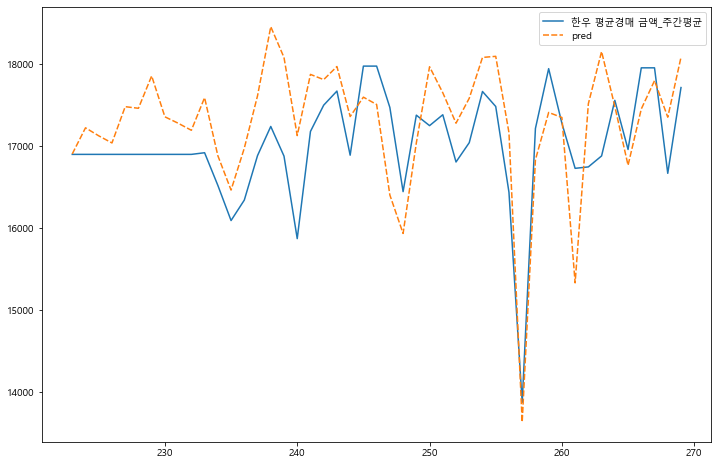

In [55]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','1~2세(모든 소)'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

소 개체 수 데이터에서 추출한 변수 2개 중 하나만 제외하여도 rmse값이 높아짐.


### 반입량 관련 변수 추가

In [56]:
data = data2.copy()

['미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외', '1~2세(모든 소)', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before', 'q_diff', 'q_diff2', 'q_diff3']
Root mean squared error:  674.9711754762831
mean absolute error:  23.485880668391594
---


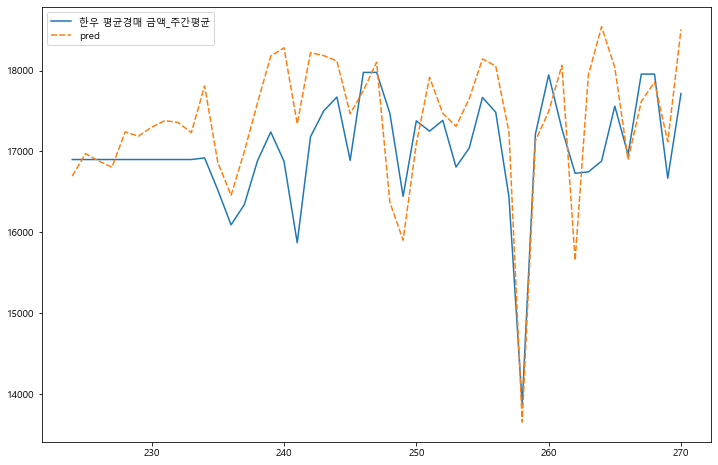

In [57]:
data['resid'] = pd.DataFrame(result_mul.resid).reset_index()['resid']

data['y_sd'] = ''
data['y_before'] = ''

data = data.reset_index()

for i in range(1,len(data['resid'])-1):
    data['y_sd'][i] = data['resid'][i-1]-np.nanmean(data['resid'])
    data['y_before'][i+1] = data['resid'][i-1]

# 반입량 변수 추가 
data['q_diff'] = data['번식우 아닌 소 중 1세 미만(암,수) 제외'].diff()
data['q_diff2'] = data['1~2세(모든 소)'].diff()
data['q_diff3'] = data['수입소고기_총량'].diff()

data_ex = data.dropna(axis=0)

del data_ex['index']
del data_ex['resid']

# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
print(features)

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

Root mean squared error:  618.1534177873773
mean absolute error:  22.70136111706069
---


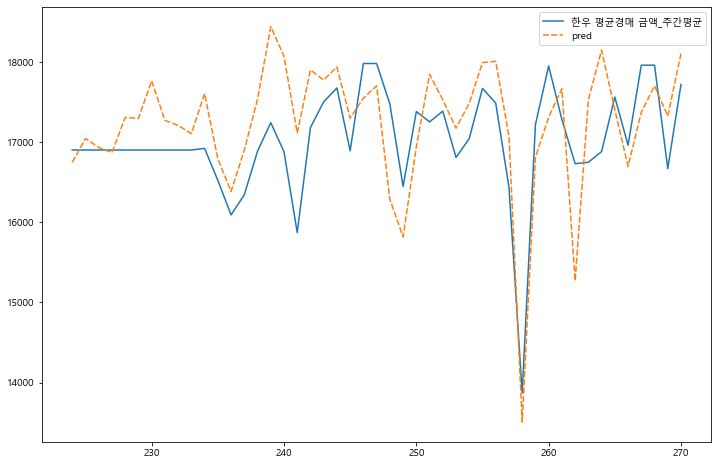

In [58]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff3'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

Root mean squared error:  702.9174654218521
mean absolute error:  24.06230089366388
---


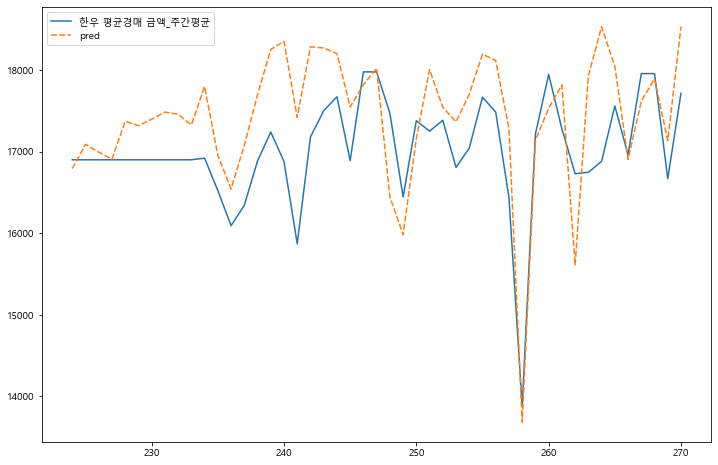

In [59]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff2'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

Root mean squared error:  564.6297603415076
mean absolute error:  21.133399797733627
---


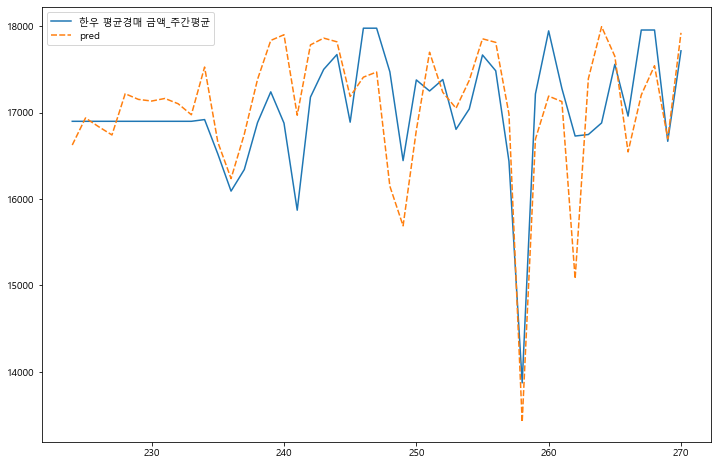

In [60]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

Root mean squared error:  570.8363217262574
mean absolute error:  21.306391310503074
---


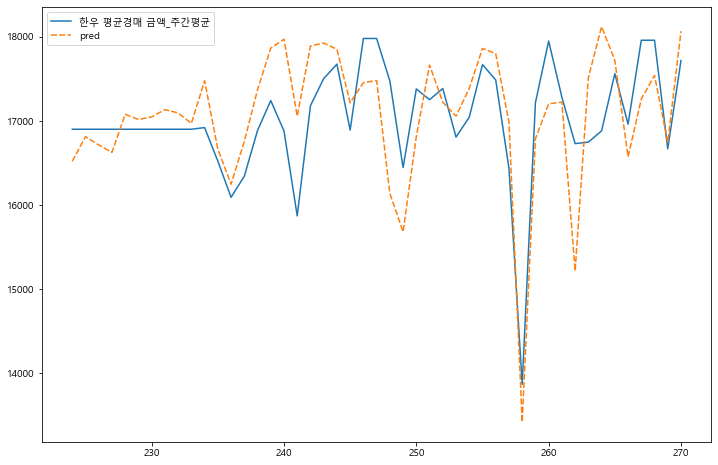

In [61]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff', 'q_diff2'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
features

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

['미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외', '1~2세(모든 소)', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before', 'q_diff']
Root mean squared error:  572.0987410107957
mean absolute error:  21.561903455897788
---


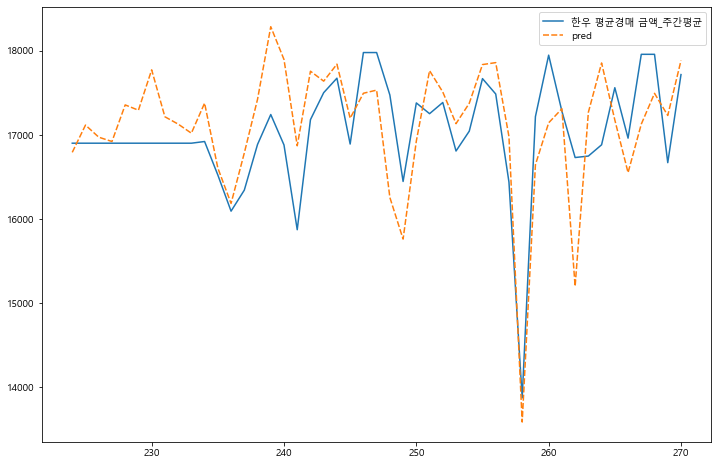

In [63]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff3', 'q_diff2'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
print(features)

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

['미국소_생산량(가격화한값)', '번식우 아닌 소 중 1세 미만(암,수) 제외', '1~2세(모든 소)', '돼지 탕박 경매 금액_주간평균', '수출 (100만달러)', '수입 (100만달러)', '소비자물가지수 (2010=100)', '수입소고기_총량', '평균기온', '최저기온', '최고기온', '평균지면온도', '최소상대습도(%)', '평균상대습도(%)', 'y_sd', 'y_before', 'q_diff2']
Root mean squared error:  608.1575641811313
mean absolute error:  22.692363433531963
---


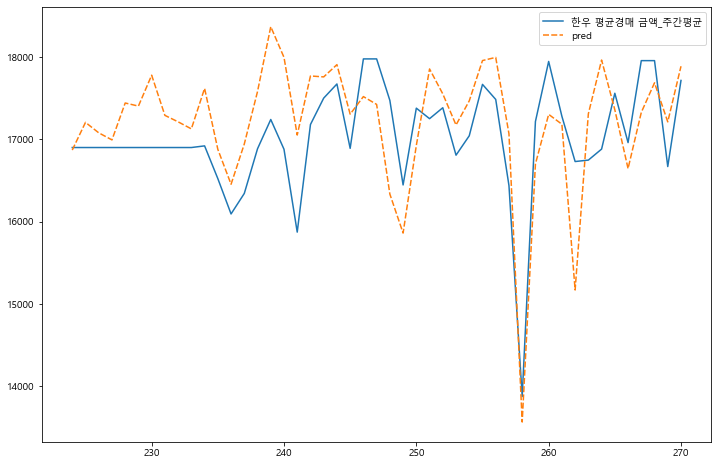

In [64]:
# 변수명 추출
data_names = data_ex.drop(['주간날짜','한우 평균경매 금액_주간평균','q_diff3', 'q_diff'],axis=1).columns
data_names = [list(i) for i in data_names]
features = [''.join(i) for i in data_names]
print(features)

ma_scaler = preprocessing.MaxAbsScaler()
np_scaled_data = ma_scaler.fit_transform(data_ex[features])
scaled_data = data_ex.copy()

scaled_data[features] = np_scaled_data

train = scaled_data[scaled_data['주간날짜'] <= split_date].copy()
test = scaled_data[scaled_data['주간날짜'] > split_date].copy()

train_x = train[features]
train_y = train['한우 평균경매 금액_주간평균']

test_x = test[features]
test_y = test['한우 평균경매 금액_주간평균']

regressor=MLPRegressor(hidden_layer_sizes=[128, 64, 32], max_iter=500, alpha=0.05, batch_size=10)

regressor.fit(train_x,train_y)

pred = regressor.predict(test_x)

test['pred'] = pred

plt.figsize = (15,10)
sns.lineplot(data = test[['한우 평균경매 금액_주간평균','pred']])

# 성능 
mse = mean_squared_error(test['한우 평균경매 금액_주간평균'], pred)
mae = mean_absolute_error(test['한우 평균경매 금액_주간평균'], pred)

print('Root mean squared error: ', np.sqrt(mse))
print('mean absolute error: ', np.sqrt(mae))
print('---')

### 추가로 해야하는 부분
MACD 좌표 구하기
MACD는 이동평균수렴확산짖수로 이동평균선끼리의 차이를 통해 주가 흐름을 알아보는데 쓰이는 지표로 우리는 가격추세 전환지점 포착 지표로 사용할 것임.
ewm 함수를 이용하여 구현 가능